## LLM Embeddings + Scikit-learn Pipeline (Modular Version)

This notebook uses modular code from `src/` to:
- Load and preprocess text + structured features
- Encode text using multiple LLM embedding models
- Combine them with structured data
- Train and evaluate Scikit-learn models
- Visualize with t-SNE

### Load dataset

https://machinelearningmastery.com/feature-engineering-with-llm-embeddings-enhancing-scikit-learn-models/ 


In [5]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import sys
import os
__file__="notebook"
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
from src.embedding_pipeline import get_embeddings, scale_features, combine_features
from src.model_utils import train_classifier, evaluate_model, visualize_tsne
import numpy as np

# Load dataset
url = "https://raw.githubusercontent.com/gakudo-ai/open-datasets/refs/heads/main/customer_support_dataset.csv"
df = pd.read_csv(url)

# Extract features
text_data = df["text"].tolist()
structured_data = df[["prior_tickets", "account_age_days"]].values
labels = df["label"].tolist()


### Define Embedding Models

In [9]:
from sentence_transformers import SentenceTransformer

# Dictionary of model names to load
embedding_models = {
    "MiniLM-L6-v2": "all-MiniLM-L6-v2",
    "MiniLM-L12-v2": "paraphrase-MiniLM-L12-v2",
    "MiniLM-QA": "multi-qa-MiniLM-L6-cos-v1",
    "BGE-Small": "BAAI/bge-small-en-v1.5"
}


### Shared Preprocessing

In [11]:
# Extract features
text_data = df["text"].tolist()
structured_data = df[["prior_tickets", "account_age_days"]].values
labels = df["label"].tolist()

# Scale structured data once
scaler = StandardScaler()
X_structured_scaled = scaler.fit_transform(structured_data)


### Train & Evaluate Each Model

In [14]:
from sklearn.model_selection import train_test_split

structured_scaled = scale_features(structured_data)
results = []

for name, model_name in embedding_models.items():
    print(f"\n🔄 Embedding using: {name}")
    X_text = get_embeddings(text_data, model_name)
    X_combined = combine_features(structured_scaled, X_text)

    X_train, X_test, y_train, y_test = train_test_split(X_combined, labels, stratify=labels, test_size=0.2, random_state=42)
    clf = train_classifier(X_train, y_train)
    metrics = evaluate_model(clf, X_test, y_test)

    results.append({"Model": name, **metrics})





🔄 Embedding using: MiniLM-L6-v2


Batches: 100%|██████████| 2/2 [00:00<00:00, 19.32it/s]


              precision    recall  f1-score   support

     billing       1.00      1.00      1.00         2
         bug       1.00      1.00      1.00         2
    delivery       1.00      1.00      1.00         2
       login       1.00      1.00      1.00         2
      refund       1.00      1.00      1.00         2

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10


🔄 Embedding using: MiniLM-L12-v2


Batches: 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]
c:\Users\Walid\Documents\Work\LLM_Embedding_ML\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Walid\Documents\Work\LLM_Embedding_ML\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Walid\Documents\Work\LLM_Embedding_ML\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

              precision    recall  f1-score   support

     billing       0.67      1.00      0.80         2
         bug       1.00      1.00      1.00         2
    delivery       0.00      0.00      0.00         2
       login       0.67      1.00      0.80         2
      refund       1.00      1.00      1.00         2

    accuracy                           0.80        10
   macro avg       0.67      0.80      0.72        10
weighted avg       0.67      0.80      0.72        10


🔄 Embedding using: MiniLM-QA


Batches: 100%|██████████| 2/2 [00:00<00:00, 20.25it/s]


              precision    recall  f1-score   support

     billing       1.00      1.00      1.00         2
         bug       1.00      0.50      0.67         2
    delivery       1.00      1.00      1.00         2
       login       0.67      1.00      0.80         2
      refund       1.00      1.00      1.00         2

    accuracy                           0.90        10
   macro avg       0.93      0.90      0.89        10
weighted avg       0.93      0.90      0.89        10


🔄 Embedding using: BGE-Small


Batches: 100%|██████████| 2/2 [00:00<00:00, 12.02it/s]


              precision    recall  f1-score   support

     billing       1.00      1.00      1.00         2
         bug       1.00      1.00      1.00         2
    delivery       0.67      1.00      0.80         2
       login       1.00      1.00      1.00         2
      refund       1.00      0.50      0.67         2

    accuracy                           0.90        10
   macro avg       0.93      0.90      0.89        10
weighted avg       0.93      0.90      0.89        10



### Store & Compare Results

In [15]:
results_df = pd.DataFrame(results).sort_values(by="F1 (Weighted)", ascending=False)
results_df


,Model,Accuracy,F1 (Weighted)
0,MiniLM-L6-v2,1.0,1.000000
2,MiniLM-QA,0.9,0.893333
3,BGE-Small,0.9,0.893333
1,MiniLM-L12-v2,0.8,0.720000


### Visualize Embeddings

Batches: 100%|██████████| 2/2 [00:00<00:00, 19.33it/s]


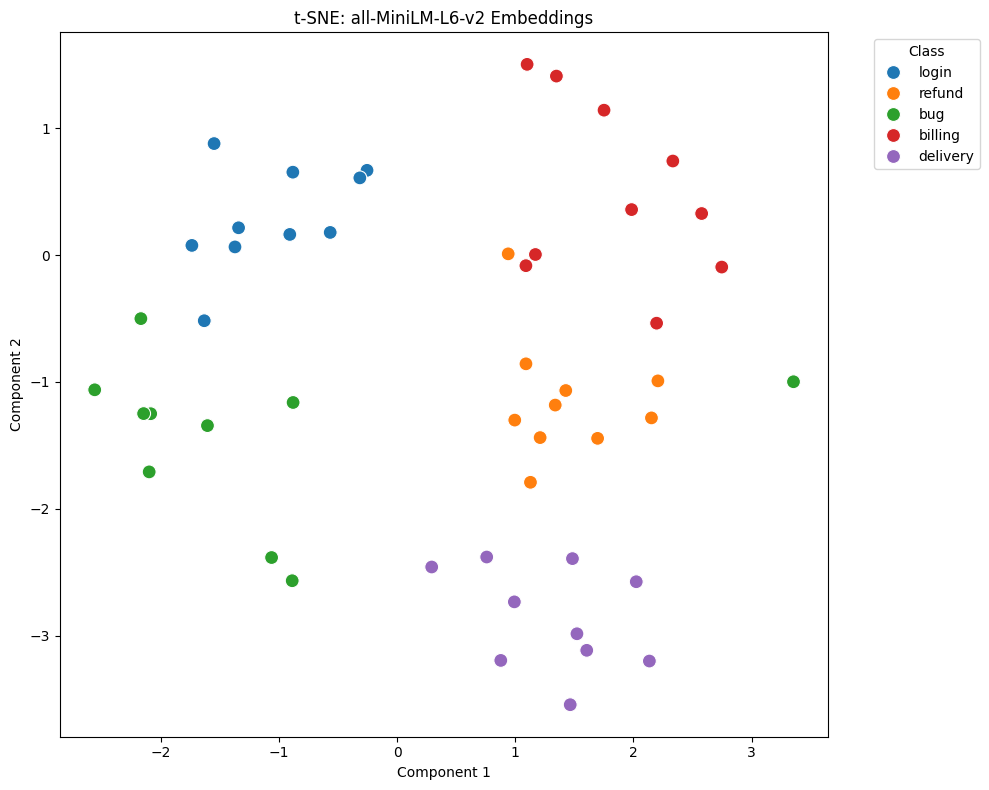

In [17]:
best_model = "all-MiniLM-L6-v2"
X_text = get_embeddings(text_data, best_model)
visualize_tsne(X_text, labels, title=f"t-SNE: {best_model} Embeddings")
